1. download whole checking history
2. download this month's cc history, overlapping start date with previous csv's end date
3. change FINAL_MONTH and checking_df import 

In [2]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
BONUS_THRESH = 4_000

START_BALANCE = 10896.91

START_YEAR, START_MONTH, START_DAY = 2022, 9, 1
FINAL_YEAR, FINAL_MONTH, FINAL_DAY = 2024, 12, 31  # inclusive

In [15]:
def reformat_date(dash_date: str) -> str:  # from "yyyy-mm-dd" to "mm/dd/yyyy"
    yyyy, mm, dd = dash_date.split("-")
    return "/".join([mm, dd, yyyy])

In [65]:
credit_chase_dfs = [
    pd.read_csv(f"data/chase/{path}") for path in os.listdir("data/chase/") if path.startswith("Chase3098")
]
for i in range(len(credit_chase_dfs)):
    credit_chase_dfs[i]["Card"] = "Sapphire Preferred"

credit_capital_one_dfs = [pd.read_csv(f"data/capital_one/{path}") for path in os.listdir("data/capital_one/")]
for i in range(len(credit_capital_one_dfs)):
    credit_capital_one_dfs[i]["Posted Date"] = credit_capital_one_dfs[i]["Posted Date"].apply(reformat_date)

    credit_capital_one_dfs[i]["Amount"] = -credit_capital_one_dfs[i]["Debit"].combine_first(
        -credit_capital_one_dfs[i]["Credit"]
    )
    credit_capital_one_dfs[i] = credit_capital_one_dfs[i].rename({"Posted Date": "Post Date"}, axis="columns")[
        ["Post Date", "Description", "Category", "Amount"]
    ]

    credit_capital_one_dfs[i]["Card"] = "VentureX"

credit_df = pd.concat(credit_chase_dfs + credit_capital_one_dfs).reset_index(drop=True)[
    ["Card", "Post Date", "Description", "Category", "Amount"]
]
credit_df = credit_df.sort_values("Post Date", ascending=True, ignore_index=True)

credit_df = credit_df.rename({"Post Date": "Posting Date"}, axis="columns")
credit_df["Posting Date"] = pd.to_datetime(credit_df["Posting Date"])

checking_df = pd.read_csv("data\chase\Chase7113_Activity_20250104.CSV", index_col=False)
checking_df["Posting Date"] = pd.to_datetime(checking_df["Posting Date"])
checking_df = checking_df.sort_values("Posting Date", ascending=True, ignore_index=True)

# Start from Sept 2022 (first stable post-moving month)
credit_df = credit_df[credit_df["Posting Date"] >= datetime.datetime(day=START_DAY, month=START_MONTH, year=START_YEAR)]
checking_df = checking_df[
    checking_df["Posting Date"] >= datetime.datetime(day=START_DAY, month=START_MONTH, year=START_YEAR)
]

# End at last month
credit_df = credit_df[credit_df["Posting Date"] <= datetime.datetime(day=FINAL_DAY, month=FINAL_MONTH, year=FINAL_YEAR)]
checking_df = checking_df[
    checking_df["Posting Date"] <= datetime.datetime(day=FINAL_DAY, month=FINAL_MONTH, year=FINAL_YEAR)
]

# process
checking_df = checking_df[checking_df["Type"] != "MISC_DEBIT"]
checking_df["Balance"] = checking_df.Balance.astype(np.float64)


# Add month col for grouping
credit_df["month"] = pd.to_datetime(
    credit_df["Posting Date"].dt.year.astype(str) + "-" + credit_df["Posting Date"].dt.month.astype(str)
)
checking_df["month"] = pd.to_datetime(
    checking_df["Posting Date"].dt.year.astype(str) + "-" + checking_df["Posting Date"].dt.month.astype(str)
)

### 1. Prep debit expenses table

In [66]:
credit_df

,Card,Posting Date,Description,Category,Amount,month
0,Sapphire Preferred,2023-01-01,THAI SPICE RICE AND NOOD,Food & Drink,-14.99,2023-01-01
1,Sapphire Preferred,2023-01-01,TST* Cookshack 3,Food & Drink,-15.84,2023-01-01
2,Sapphire Preferred,2023-01-01,THAI COTTAGE AT THE BAY,Food & Drink,-26.00,2023-01-01
3,Sapphire Preferred,2024-01-01,TST* ROCK NUETNEYS,Food & Drink,-13.38,2024-01-01
4,Sapphire Preferred,2023-01-03,UNITED 0162455897626,Travel,-308.75,2023-01-01
...,...,...,...,...,...,...
2286,Sapphire Preferred,2022-12-30,CHICK-FIL-A #03274,Food & Drink,-12.10,2022-12-01
2287,Sapphire Preferred,2022-12-30,SQ *DIMASSI?S WEBSTER,Food & Drink,-17.31,2022-12-01
2288,VentureX,2024-12-30,Celebrity Series,Entertainment,-336.00,2024-12-01
2289,Sapphire Preferred,2024-12-31,MIAS - BAY AREA,Food & Drink,-21.52,2024-12-01


In [118]:
debit_df = checking_df[checking_df.Amount < 0]

# ignore credit card payments, since they double count cc expenses
cc_pay_keywords = ["Payment to Chase card", "CHASE CREDIT CRD", "MOBILE PMT", "CRCARDPMT"]
debit_df = debit_df[~pd.DataFrame([debit_df.Description.str.contains(kw) for kw in cc_pay_keywords]).any(axis=0)]

### 2. Prep credit expenses table

In [119]:
# drop cc payments
cc_pay_keywords = [
    "Returned Payment",
    "Payment Thank You",
    "AUTOMATIC PAYMENT - THANK",
    "AUTOPAY PMT",
    "CAPITAL ONE MOBILE PYMT",
    "CAPITAL ONE AUTOPAY PYMT",
]
credit_df = credit_df[~pd.DataFrame([credit_df.Description.str.contains(kw) for kw in cc_pay_keywords]).any(axis=0)]

### 3. Prep income table

In [312]:
income_df = checking_df[checking_df.Amount > 0]

# partition out paychecks
paycheck_df = income_df[income_df.Description.str.contains("MICROSOFT")]
income_df = income_df.drop(paycheck_df.index, axis=0)

# separate bonuses from paychecks
bonus_rows = []
for i, (idx, row) in enumerate(paycheck_df.iterrows()):
    if row.Amount > 4_000:
        # get bonus amount by comparing to surrounding paychecks
        if (i + 1 < len(paycheck_df)) and paycheck_df.iloc[i + 1].Amount > 2000:
            bonus_amt = row.Amount - paycheck_df.iloc[i + 1].Amount
        elif i != 0 and paycheck_df.iloc[i - 1].Amount > 2000:
            bonus_amt = row.Amount - paycheck_df.iloc[i - 1].Amount
        else:
            raise Exception("no valid paycheck to compare")

        # update paycheck_df
        paycheck_df.loc[idx, "Amount"] -= bonus_amt

        bonus_row = row.copy()
        row.Amount = bonus_amt

        # save bonus row
        bonus_rows.append(row)
bonus_df = pd.DataFrame(bonus_rows)

# partition out stocks (+ other random bonus looking things)
stock_keywords = ["SCHWAB", "NORTH LANE", "REAL TIME TRANSFER", "Morgan", "IRS", "COMM.", "FID"]
stock_df = income_df[pd.DataFrame([income_df.Description.str.contains(kw) for kw in stock_keywords]).any(axis=0)]

# remaining things are refunds related to specific expenses
refund_df = income_df.drop(stock_df.index)

# income line items
income_dfs = [paycheck_df, bonus_df, stock_df, refund_df]

income_df = pd.concat(income_dfs, axis=0).sort_values("Posting Date").reset_index(drop=True)

## Assign categories to new transactions

In [125]:
# load categories of old transactions
expense_df_prev_categories = (
    pd.read_csv("expense.csv", index_col=0)
    .sort_values(["Posting Date", "Description", "Amount"], inplace=False)
    .reset_index()
    .drop(columns="level_0")
)

expense_df = (
    pd.concat([debit_df, credit_df])
    .sort_values(["Posting Date", "Description", "Amount"], inplace=False)
    .reset_index()
    .drop(columns="index")
)



expense_df["Category"] = None
expense_df_prev_categories = (

    expense_df_prev_categories.sort_values(["Posting Date", "Description", "Amount"], inplace=False)
    .reset_index()

    .drop(columns="level_0")
)



expense_df.loc[: len(expense_df_prev_categories), "Category"] = expense_df_prev_categories["Category"]
del expense_df_prev_categories


expense_df["Category"] = None

In [139]:
cat_instructions = """1. Bills
2. Grocery
3. Necessary meals
4. Social food/drinks
5. Transit
6. Travel
7. Entertainment
8. Venmo
9. Shopping
10. Clothing
11. Haircut
12. Medical
13. Exercise
14. Medication
15. Subscriptions
16. Investments"""
rules = {
    "Bills": ["bozzuto", "eversource", "xfinity", "comcast", "lpcresi", "*google stora", "tjx rewa"],
    "Grocery": ["brothers", "wholef"],
    "Necessary meals": [
        "chipotle",
        "aceituna",
        "uber   eats",
        "doordash",
        "subway",
        "oxxo",
        "bon me",
        "tatte",
        "cava",
        "postmat",
        "mcdona",
        "instacar",
        "dunkin",
        "chowbus",
        "uber   *eats",
    ],
    "Social food/drinks": [
        "zuma",
        "bar taco",
        "conces",
        "cask 'n",
        "shy bird",
        "harp",
        "phoenix",
        "flat top",
        "cheeky",
        "carrie nation",
        "bell in",
    ],
    "Transit": [
        "mta",
        "mbta",
        "uber   trip",
        "lime",
        "bluebike",
        "beam",
        "uber *trip",
        "lim*ride",
        "bixi",
        "uber   *trip",
    ],
    "Travel": ["airbnb", "united", "amtrak", "delta", "zipcar toll", "zipcar trip", "zipcar extend", "zipcar late"],
    "Entertainment": [
        "ticketmaster",
        "gametime",
        "stubhub",
        "tickpick",
        "lucky strike",
        "golf",
        "seatgeek",
        "astros",
        "red sox",
    ],
    "Venmo/Cash": ["venmo", "non-chase atm", "zelle"],
    "Shopping": ["amazon", "target", "amzn"],
    "Clothing": ["express"],
    "Haircut": [],
    "Medical": ["colleen", "willems", "bspt", "dds"],
    "Exercise": ["usta", "volo"],
    "Medication": ["pharmacy"],
    "Subscriptions": ["zipcar monthly", "mlb.tv", "relayforre"],
    "Investments": ["schwab"],
}
rules_map = {}
for cat, vals in rules.items():
    for val in vals:
        rules_map[val] = cat
num_map = [cat for cat in rules.keys()]

for i in range(len(expense_df)):
    # expense_df.iloc[i, expense_df.columns.get_loc("Category")] = None
    if expense_df.iloc[i, expense_df.columns.get_loc("Category")] is not None:
        continue
    for key in rules_map.keys():
        if key in expense_df.iloc[i]["Description"].lower():
            expense_df.iloc[i, expense_df.columns.get_loc("Category")] = rules_map[key]
            break
    print(
        expense_df.iloc[i, expense_df.columns.get_loc("Description")],
        expense_df.iloc[i, expense_df.columns.get_loc("Category")],
    )

VETRAI 75 None
RedCoach Texas LLC None
USCUSTOMS TRUSTEDTRAVELER None
CAMBRIDGE HEALTH MYCHART None
CHEESECAKE BAYBROOK None
CHEESECAKE BAYBROOK None
H-E-B #713 None
IHOP 1421 None
MICHAELS STORES 5114 None
MOZARTS COFFEE ROASTERS None
RAISING CANES 0161 None
SQ *AUSTIN- HOUNDSTOOTH D None
SQ *GAJIC COACHING LLC None
TERRY BLACKS BARBECUE None
TERRY BLACKS BARBECUE None
TST* Ramen Tatsu-Ya - Sou None
WALGREENS #5709 None
H-E-B #713 None
TST* ALL STAR SANDWICH BA None
TST* BOM DOUGH None
USAA INSURANCE PAYMENT None
DELAWARE NORTH LOGAN F&amp;B None
IN N OUT BURGER 326 None
J. CREW #502 None
KOJA KITCHEN SF None
TST* State Bird Provision None
UA INFLT    0164219226794 None
IN N OUT BURGER 159 None
K POP  - SF None
TST* Victory Hall &amp; Parlo None
CALTRAIN None
TST* Udon Mugizo - San Fr None
99 RANCH #1768 None
COMMUNITY BOATING INC None
DUMPLING HOUSE None
TST* Boston Doner None
SOJUBA None
STEAMGAMES.COM 4259522985 None
TM *YANKEES V ASTROS Entertainment
CAMBRIDGE HEALTH TC ACH     03

In [140]:
print("Left:", expense_df["Category"].isna().sum())
print(expense_df["Description"][expense_df["Category"].isna()].tolist())

Left: 789
['VETRAI 75', 'RedCoach Texas LLC', 'USCUSTOMS TRUSTEDTRAVELER', 'CAMBRIDGE HEALTH MYCHART', 'CHEESECAKE BAYBROOK', 'CHEESECAKE BAYBROOK', 'H-E-B #713', 'IHOP 1421', 'MICHAELS STORES 5114', 'MOZARTS COFFEE ROASTERS', 'RAISING CANES 0161', 'SQ *AUSTIN- HOUNDSTOOTH D', 'SQ *GAJIC COACHING LLC', 'TERRY BLACKS BARBECUE', 'TERRY BLACKS BARBECUE', 'TST* Ramen Tatsu-Ya - Sou', 'WALGREENS #5709', 'H-E-B #713', 'TST* ALL STAR SANDWICH BA', 'TST* BOM DOUGH', 'USAA INSURANCE PAYMENT', 'DELAWARE NORTH LOGAN F&amp;B', 'IN N OUT BURGER 326', 'J. CREW #502', 'KOJA KITCHEN SF', 'TST* State Bird Provision', 'UA INFLT    0164219226794', 'IN N OUT BURGER 159', 'K POP  - SF', 'TST* Victory Hall &amp; Parlo', 'CALTRAIN', 'TST* Udon Mugizo - San Fr', '99 RANCH #1768', 'COMMUNITY BOATING INC', 'DUMPLING HOUSE', 'TST* Boston Doner', 'SOJUBA', 'STEAMGAMES.COM 4259522985', 'CAMBRIDGE HEALTH TC ACH     035-0173650242  WEB ID: 9000539437', 'WL *Steam Purchase', 'UBER* TRIP', 'HONG KONG BOSTON', 'TST* Tr

In [152]:
from IPython.display import clear_output

print("Left:", expense_df["Category"].isna().sum())
for i in range(len(expense_df)):
    if expense_df.iloc[i, expense_df.columns.get_loc("Category")] is None:
        print(
            expense_df.iloc[i, expense_df.columns.get_loc("Posting Date")],
            expense_df.iloc[i, expense_df.columns.get_loc("Description")],
            expense_df.iloc[i, expense_df.columns.get_loc("Amount")],
        )
        print(cat_instructions)
        try:
            cat_idx = int(input()) - 1  # zero index!
        except:
            clear_output()
            print(
                expense_df.iloc[i, expense_df.columns.get_loc("Posting Date")],
                expense_df.iloc[i, expense_df.columns.get_loc("Description")],
                expense_df.iloc[i, expense_df.columns.get_loc("Amount")],
            )
            print(cat_instructions)
            try:
                cat_idx = int(input()) - 1  # zero index!
            except:
                clear_output()
                print(
                    expense_df.iloc[i, expense_df.columns.get_loc("Posting Date")],
                    expense_df.iloc[i, expense_df.columns.get_loc("Description")],
                    expense_df.iloc[i, expense_df.columns.get_loc("Amount")],
                )
                print(cat_instructions)
                cat_idx = int(input()) - 1  # zero index!
        clear_output()
        expense_df.iloc[i, expense_df.columns.get_loc("Category")] = num_map[cat_idx]

Left: 0


In [298]:
expense_df.to_csv("expense.csv")

### Net worth, typical/nontypical expenses

In [196]:
nontypical_expense_keywords = ["SCHWAB", "TAXPY"]
expense_df_nontypical = expense_df[
    pd.DataFrame([expense_df.Description.str.contains(kw) for kw in nontypical_expense_keywords]).any(axis=0)
]
expense_df_typical = expense_df.drop(expense_df_nontypical.index)

In [197]:
net_df = pd.concat([expense_df] + income_dfs).sort_values("Posting Date")

In [198]:
expense_df_typical_monthly = -expense_df_typical.groupby("month").Amount.sum()
expense_df_nontypical_monthly = -expense_df_nontypical.groupby("month").Amount.sum()
expense_df_monthly = -expense_df.groupby("month").Amount.sum()

In [199]:
net_worth_df = pd.DataFrame(
    [df.groupby("month").Amount.sum() for df in income_dfs],
    index=["Paycheck", "Bonus", "Stock/Tax Return", "Misc/Refund"],
).T

net_worth_df["Typical Expenses"] = -expense_df_typical_monthly
net_worth_df["Atypical Expenses"] = -expense_df_nontypical_monthly
net_worth_df = net_worth_df.fillna(0)

In [ ]:
net_worth_df

,Paycheck,Bonus,Stock/Tax Return,Misc/Refund,Typical Expenses,Atypical Expenses
month,,,,,,
2023-01-01,6283.90,0.00,0.00,20.00,-9508.24,0.0
2023-02-01,5770.38,0.00,12034.33,0.00,-7271.65,-4212.0
2023-03-01,5757.47,0.00,0.00,146.27,-9032.51,0.0
2023-04-01,5757.46,2672.89,0.00,511.60,-6657.78,0.0
2023-05-01,5757.50,0.00,0.00,633.00,-7301.57,0.0
2023-06-01,5757.48,0.00,0.00,0.00,-8397.89,0.0
2023-07-01,5757.48,9754.80,0.00,0.00,-9790.68,0.0
2023-08-01,5866.75,0.00,0.00,271.43,-8847.24,0.0
2023-09-01,6094.10,7271.89,0.00,2120.00,-10803.33,-7000.0


## Monthly questions

### Am I close to running out of money?

In [320]:
(START_BALANCE + net_worth_df.sum(axis=1).cumsum())

month
2023-01-01     7692.57
2023-02-01    14013.63
2023-03-01    10884.86
2023-04-01    13169.03
2023-05-01    12257.96
2023-06-01     9617.55
2023-07-01    15339.15
2023-08-01    12630.09
2023-09-01    10312.75
2023-10-01     8473.33
2023-11-01     6551.38
2023-12-01     6223.99
2024-01-01     5258.17
2024-02-01     4494.84
2024-03-01     4098.14
2024-04-01     4117.57
2024-05-01     1404.72
2024-06-01     4657.80
2024-07-01      950.69
2024-08-01     1914.31
2024-09-01     8519.56
2024-10-01     3227.58
2024-11-01      498.30
2024-12-01      368.43
Freq: MS, dtype: float64

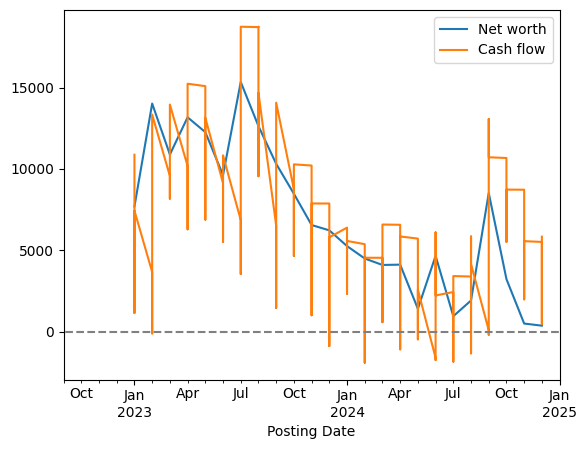

In [351]:
(START_BALANCE + net_worth_df.sum(axis=1).cumsum()).plot()
(START_BALANCE + checking_df.groupby("Posting Date").Amount.sum().cumsum()).plot()
plt.hlines(0, 0, 10000, colors="gray", linestyles="dashed")
plt.legend(["Net worth", "Cash flow"])
_ = plt.xlim(
    [
        datetime.datetime(day=START_DAY, month=START_MONTH, year=START_YEAR),
        datetime.datetime(
            day=FINAL_DAY,
            month=(FINAL_MONTH + 1) if FINAL_MONTH < 12 else 1,
            year=(FINAL_YEAR + 1 if FINAL_MONTH == 12 else FINAL_YEAR),
        ),
    ]
)

### How did I spend differently this month?

In [366]:
def compare_medians(medians: pd.Series, expense_df: pd.DataFrame, month_range=FINAL_MONTH):
    if isinstance(month_range, int):
        month_range = [month_range, month_range]
    n_months = month_range[1] - month_range[0] + 1

    this_month_expense_df = expense_df[
        (datetime.datetime(day=1, month=month_range[0], year=FINAL_YEAR) <= expense_df["month"])
        & (expense_df["month"] <= datetime.datetime(day=1, month=month_range[1], year=FINAL_YEAR))
    ]

    this_month_categories = -this_month_expense_df.groupby("Category").Amount.sum().sort_values()


    # plot this month as a diff from medians

    diff = (this_month_categories - (medians * n_months)) / n_months

    expense_df_last_12_months = expense_df[
        (datetime.datetime(day=1, month=month_range[0], year=FINAL_YEAR - 1) <= expense_df["month"])
        & (expense_df["month"] < datetime.datetime(day=1, month=month_range[0], year=FINAL_YEAR))
    ]
    print(
        f"# Median month spending over last year:", (-expense_df_last_12_months.groupby("month").Amount.sum().median())
    )
    print("# These months' spending:", -this_month_expense_df.Amount.sum() / n_months, "/ month")
    print()
    print("# vs. previous 12 months:")
    print("## per month:")

    print(
        pd.DataFrame(
            {
                "Diff": diff,
                "Median": medians,
                "This month": this_month_categories / n_months,
            }
        ).sort_values("Diff", ascending=False)
    )
    print()
    print("## total:")
    print(
        pd.DataFrame(
            {"Diff": diff * n_months, "Median": medians * n_months, "This month": this_month_categories}
        ).sort_values("Diff", ascending=False)
    )

    top_categories = diff.sort_values(ascending=False).index[:3]

    return this_month_expense_df, top_categories


def print_categories(this_month_expense_df: pd.DataFrame, categories: list):
    # look at the expenses from top few categories
    for cat in categories:
        print()
        print(cat)
        print(
            this_month_expense_df[this_month_expense_df["Category"] == cat][
                ["Description", "Amount", "Posting Date"]
            ].sort_values("Amount")
        )

In [367]:
month_range = [1, 12]

last_12_months_expense_df = expense_df[

    (datetime.datetime(day=1, month=month_range[0], year=FINAL_YEAR - 1) <= expense_df["month"])
    & (expense_df["month"] < datetime.datetime(day=1, month=month_range[0], year=FINAL_YEAR))
]



last_12_months_category_medians = (
    -last_12_months_expense_df.groupby(["Category", "month"]).Amount.sum().groupby("Category").median().sort_values()
)



this_month_expense_df, top_categories = compare_medians(
    last_12_months_category_medians, expense_df, month_range=month_range
)

this_month_income_df = income_df[
    (datetime.datetime(day=1, month=month_range[0], year=FINAL_YEAR) <= income_df["month"])
    & (income_df["month"] <= datetime.datetime(day=1, month=month_range[1], year=FINAL_YEAR))
]

# Median month spending over last year: 8863.564999999999
# These months' spending: 9360.130833333335 / month

# vs. previous 12 months:
## per month:
                          Diff    Median   This month
Category                                             
Social food/drinks  433.641667   750.640  1184.281667
Venmo/Cash          423.437500   398.200   821.637500
Entertainment       403.356667   459.695   863.051667
Bills               243.807500  4105.430  4349.237500
Shopping            110.428333   310.500   420.928333
Grocery              61.035833   104.280   165.315833
Medical              47.881667   235.705   283.586667
Subscriptions        34.605000     8.500    43.105000
Exercise              8.375833    39.325    47.700833
Medication            3.871667    36.200    40.071667
Transit             -30.423333   116.380    85.956667
Necessary meals     -57.309167   367.855   310.545833
Haircut             -60.173333    64.340     4.166667
Clothing           -148.929167   255.80

In [353]:
print_categories(this_month_expense_df, top_categories)


Medical
                    Description  Amount Posting Date
2594  HOPPING EYE ASSOCIATES LL -932.92   2024-10-23
2485                   BSPT-CAM -193.14   2024-10-06
2596  PHR*FondrenOrthopedicGrou  -20.09   2024-10-23
2508                   BSPT-CAM   -9.14   2024-10-10

Clothing
                   Description  Amount Posting Date
2562  Ralph Lauren Corporation -817.56   2024-10-18

Travel
                    Description  Amount Posting Date
2483  UNITED      0162425248734 -458.97   2024-10-04
2476        AIRBNB * HMNMABHXH9 -279.87   2024-10-04
2535            AVIS RENT-A-CAR -148.66   2024-10-14


In [347]:
print_categories(this_month_expense_df, ["Bills"])


Bills
                                            Description   Amount Posting Date
2469  LPCRESIDENT3-225 WEB PMTS   VX3W5H          WE... -3931.00   2024-10-03
2521                             CAPITAL ONE MEMBER FEE  -395.00   2024-10-11
2509  EVERSOURCE       WEB_PAY    61797875092524  WE...  -127.51   2024-10-10
2454                              ANNUAL MEMBERSHIP FEE   -95.00   2024-10-01
2522  COMCAST 8773102  263397871                  PP...   -85.93   2024-10-11
2583  TJX REWARDS      PAYMENT    524366300420838 WE...   -30.03   2024-10-21
2545  LPCRESIDENT3-225 WEB PMTS   1NNC8H          WE...   -25.00   2024-10-15


In [332]:
this_month_income_df

,Details,Posting Date,Description,Amount,Type,Balance,Check or Slip #,month
77,CREDIT,2024-09-13,MICROSOFT EDIPAYMENT PP...,9826.48,ACH_CREDIT,14804.53,NaN,2024-09-01
78,CREDIT,2024-09-13,MICROSOFT EDIPAYMENT PP...,3213.23,ACH_CREDIT,14804.53,NaN,2024-09-01
79,CREDIT,2024-09-16,Zelle payment from BRIAN GLAZE 22079258154,250.00,QUICKPAY_CREDIT,15051.35,NaN,2024-09-01
80,CREDIT,2024-09-30,MICROSOFT EDIPAYMENT PP...,3213.23,ACH_CREDIT,12671.26,NaN,2024-09-01
81,CREDIT,2024-10-15,MICROSOFT EDIPAYMENT PP...,3213.23,ACH_CREDIT,11641.37,NaN,2024-10-01
82,CREDIT,2024-10-31,MICROSOFT EDIPAYMENT PP...,3213.23,ACH_CREDIT,10685.60,NaN,2024-10-01
83,CREDIT,2024-11-15,MICROSOFT EDIPAYMENT PP...,3417.57,ACH_CREDIT,9947.94,NaN,2024-11-01
84,CREDIT,2024-11-29,MICROSOFT EDIPAYMENT PP...,3574.54,ACH_CREDIT,7516.93,NaN,2024-11-01
